In [49]:
import numpy as np 
import pandas as pd
import altair as alt 
import re 
import os 
import ntpath
import sys
sys.path.append(r'../../.')
from commons.data_processing import *

In [50]:
# read uniprot file
## data downloaded directly from uniprot: Human Proteome, reviewed=YES, include subcellular compartment in
file = 'HumanProteome_wSubcellularComponent.tab'
file = 'HumanProteome_GOSubcellular.tab'
df = pd.read_csv(file, delimiter='\t')
cols = [c.lower().replace(' ', '_') for c in df.columns]
cols[-2:] = ['sub_location', 'cellular_compartment'] 
df.columns = cols
df.head()

In [52]:
def clean_sub_loc(s):
    s = s.replace('SUBCELLULAR LOCATION: ', ', ')
    regs = [r'\{ECO:\d+\|[a-zA-Z]+:[a-zA-Z0-9]+\}\. ', 
            r'\{ECO:\d+\|[a-zA-Z]+:[a-zA-Z0-9]+\}\.',
            r'\{ECO:\d+\|[a-zA-Z]+:[a-zA-Z0-9]+\}\; ',
            r'\{pubmed:\d+\}', r'\{ECO:\d+\}\;', r'\{ECO:\d+\}\.',
            r'\{ECO:\d+\}', r'\{.+\}\.']
    for r in regs:
        s = re.sub(r, ',', s)
    s = s.replace(';', ',')
    s = s.lower().split(',')
    s = [i.strip() for i in s]
    return [i for i in s if i !='' and i != ';']

def clean_cell_comp(s):
    if not isinstance(s, str):
        print(s)
    regs = [r'\s\[GO\:\d+\]']
    for r in regs:
        s = re.sub(r, '', s)
    return[i.strip() for i in s.lower().split(';')]

test = df.loc[:100, :].dropna()
test.loc[:, 'cellular_compartment'] = test.cellular_compartment.map(clean_cell_comp)
test

In [53]:
df.dropna(inplace=True)
df.loc[:, 'sub_location'] = df.sub_location.map(clean_sub_loc)
df.loc[:, 'cellular_compartment'] = df.cellular_compartment.map(clean_cell_comp)

In [40]:
with pd.ExcelWriter(r'.\SubLocations_CellCompartments.xlsx', mode='w') as writer:
    df[['entry', 'entry_name', 'protein_names', 'sub_location', 'cellular_compartment']].to_excel(writer, index=False, sheet_name='Locations_Compartments')

{'integral component of membrane': 23600, 'mitochondrial inner membrane': 8929, 'nucleus': 8337, 'plasma membrane': 6815, 'lysosomal membrane': 6516, 'cytoplasm': 6340, 'endosome membrane': 6330, 'mhc class ii protein complex': 6080, 'cytosol': 5269, 'nucleoplasm': 4646, 'respirasome': 3500, 'membrane': 2618, 'extracellular region': 2514, 'mitochondrion': 2458}


Text(0.5, 1.0, 'Test Data')

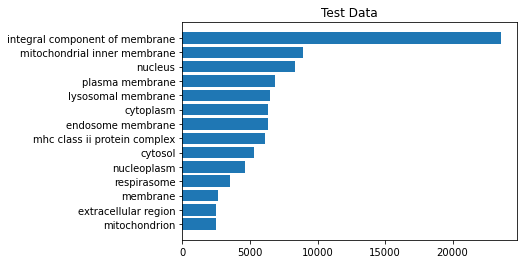

In [41]:
# Make a quick plot to see if our parsing method is reasonable
test = dict(zip(df.entry_name, df.cellular_compartment))
hist = {}
for k, v in test.items():
    for loc in v:
        hist[loc] = hist.get(loc, 0) + 1
hist = dict(sorted(hist.items(), key=lambda x: x[1], reverse=True))
highest = hist[list(hist.keys())[0]]
hist = dict([(k, v) for (k,v) in hist.items() if v >= highest * 0.1])
print(hist)

import matplotlib.pyplot as plt 
plt.barh(list(hist.keys())[::-1], list(hist.values())[::-1])
plt.title('Test Data')

In [42]:
# parse all of the PEAKS 
files = get_files(r'F:\Research\PEAKS\20200316_PANC1_Glyco_Columns\PANC1', exts=['-peptides.csv'])

In [44]:
# create a blank DataFrame
peak_frame = pd.DataFrame()
# add identifier to each file and add to DF
for file in files:
    sub = pd.read_csv(file)
    source = ntpath.dirname(file)
    source = source.split('\\')[-1]
    sub['source'] = [source]*len(sub)
    if re.search('BP', file):
        sub['source_ident'] = ['BP']*len(sub)
    elif re.search('C18', file):
        sub['source_ident'] = ['C18']*len(sub)
    else:
        sub['source_ident'] = ['PGC']*len(sub)
    if peak_frame.empty:
        peak_frame = sub
        continue
    peak_frame = pd.concat([peak_frame, sub])

In [45]:
# create sets of all proteins identified per run
# sets used here to 1) remove duplicates and 2) use for set subtraction
pgc = set(peak_frame[peak_frame.source_ident=='PGC']['Protein Accession'].tolist())
bp = set(peak_frame[peak_frame.source_ident=='BP']['Protein Accession'].tolist())
c18 = set(peak_frame[peak_frame.source_ident=='C18']['Protein Accession'].tolist())

In [54]:
# use set subtraction to pull out unique proteins
p_unique = pgc - ((pgc & c18) | (pgc & bp) | (c18 & bp) | (c18 & pgc & bp))
c_unique = c18 - ((pgc & c18) | (pgc & bp) | (c18 & bp) | (c18 & pgc & bp))
print(f'{len(p_unique)} proteins found for PGC after set subtraction')
print(f'{len(c_unique)} proteins found for C18 after set subtraction')


# create new dataframe of found proteins
found = {}
labels = ['pgc', 'c18']
for i, group in enumerate([p_unique, c_unique]):
    label = labels[i]
    accessions, names = [], []
    for item in group:
        a, n = item.split('|')
        accessions.append(a)
        names.append(n)
    found[label+'_accession'] = pd.Series(accessions)
    found[label+'_name'] = pd.Series(names)
found = pd.DataFrame(found)
found.head()

167 proteins found for PGC after set subtraction
371 proteins found for C18 after set subtraction


In [48]:
with pd.ExcelWriter(r'.\SubLocations_CellCompartments.xlsx', mode='a') as writer:
    found[['c18_accession', 'c18_name']].to_excel(writer, index=False, sheet_name='Uniqe C18 Proteins')
    found[['pgc_accession', 'pgc_name']].to_excel(writer, index=False, sheet_name='Uniqe PGC Proteins')

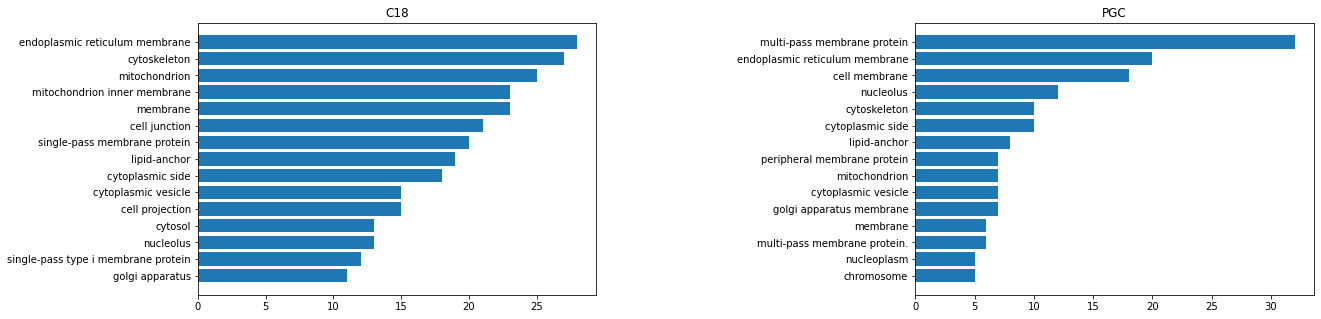

In [56]:
# make dataframes for c18 and pgc
c18_frame = df[df.entry_name.isin(found.c18_name)]
pgc_frame = df[df.entry_name.isin(found.pgc_name)]

frames = [c18_frame, pgc_frame]
labels = ['C18', 'PGC']

# plot data
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.subplots_adjust(wspace=0.8)

terms = []

for i, ax in enumerate(axs.flat):
    # make histogram for each df
    frame = frames[i]
    hist = {}
    for r in frame.sub_location:
        for item in r:
            hist[item] = hist.get(item, 0) + 1
    hist = dict(sorted(hist.items(), key=lambda x: x[1], reverse=True))
    highest = hist[list(hist.keys())[0]]
    hist = dict([(k, v) for (k,v) in hist.items() if v >= highest * 0.1])

    ys = list(hist.keys())[::-1]
    terms.append(ys)
    widths = list(hist.values())[::-1]
    ax.barh(ys[:15], widths[:15])
    ax.set_title(labels[i])
# plt.savefig('SubcellularLocation.svg')

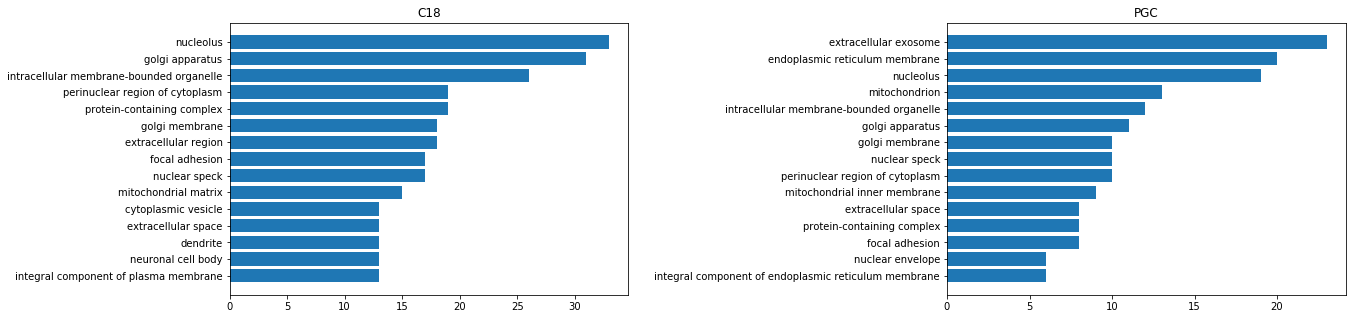

In [51]:
# make dataframes for c18 and pgc
c18_frame = df[df.entry_name.isin(found.c18_name)]
pgc_frame = df[df.entry_name.isin(found.pgc_name)]

frames = [c18_frame, pgc_frame]
labels = ['C18', 'PGC']

# plot data
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.subplots_adjust(wspace=0.8)

for i, ax in enumerate(axs.flat):
    # make histogram for each df
    frame = frames[i]
    hist = {}
    for r in frame.cellular_compartment:
        for item in r:
            hist[item] = hist.get(item, 0) + 1
    hist = dict(sorted(hist.items(), key=lambda x: x[1], reverse=True))
    highest = hist[list(hist.keys())[0]]
    hist = dict([(k, v) for (k,v) in hist.items() if v >= highest * 0.10])

    ys = list(hist.keys())[::-1]
    widths = list(hist.values())[::-1]
    ax.barh(ys[:15], widths[:15])
    ax.set_title(labels[i])
plt.savefig('CellularCompartment.svg')